# Attention Is All You Need

Статья [Attention Is All You Need](https://arxiv.org/abs/1706.03762) прежставляет архитектуру transformer. Она и ее модификации является одной из доминирующих как в бенчмарках NLP [[1]](https://paperswithcode.com/task/language-modelling), [[2]](https://paperswithcode.com/task/question-answering), [[3]](https://paperswithcode.com/task/machine-translation)  так и компьютерного зрения [[1]](https://paperswithcode.com/sota/image-classification-on-imagenet), [[2]](https://paperswithcode.com/sota/semantic-segmentation-on-ade20k), [[3]](https://paperswithcode.com/sota/object-detection-on-coco).

![](http://bbs.dian.org.cn/assets/uploads/files/1531978737341-05dd8915-607d-476b-b0a5-20fa417c1cfb-image.png)

# Реализация алгоритма

In [ ]:
#@title Импорт зависимостей
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch 
import torch.nn as nn
import math
import plotly.express as px

torch.set_printoptions(precision=4)

## Positional Encoding

На вход в трансформер подаются эмбеддинги слов фиксированного размера (d_model, размер эмбеддинга на входах кодера/декодера, по умолчанию=512). Количество слов тоже фиксированно, например 512.

В нотации статьи "i" используется для итерации по каждому компоненту векторов эмбедингов.

$$
PE_{(pos,2i)} = 
\sin \left( \frac{pos}{10000^{2i/d_{\text{model}}}} \right)
$$
$ $
$$
PE_{(pos,2i+1)} = 
\cos \left( \frac{pos}{10000^{2i/d_{\text{model}}}} \right)
$$

![](https://i.stack.imgur.com/Fhc4M.png)

Псевдокод с циклами выглядит следующим образом:

In [ ]:
def getPositionEncoding(seq_len, d, n=10000):
    P = np.zeros((seq_len, d))
    for k in range(seq_len):
        for i in np.arange(int(d/2)):
            denominator = np.power(n, 2*i/d)
            P[k, 2*i] = np.sin(k/denominator)
            P[k, 2*i+1] = np.cos(k/denominator)
    return P
 
P = getPositionEncoding(seq_len=4, d=4, n=100)
print(P)

[[ 0.          1.          0.          1.        ]
 [ 0.84147098  0.54030231  0.09983342  0.99500417]
 [ 0.90929743 -0.41614684  0.19866933  0.98006658]
 [ 0.14112001 -0.9899925   0.29552021  0.95533649]]


![](https://machinelearningmastery.com/wp-content/uploads/2022/01/PE3-1536x909.png)

In [ ]:
# максимальная длина последовательности
max_len = 4
# размер эмбеддинга токена
d_model=4

# инициализируем чтоб перезаписать
pe = torch.zeros(max_len, d_model)
print('pe:\n', pe, '\n')

# вектор-столбец
position = torch.arange(0, max_len).unsqueeze(1)
print('position:\n', position, '\n')

# при 10к появляются фигуры Лиссажу, а меньше или больше - нет :)
div_term = torch.exp(torch.arange(0, d_model, 2) *
                        -(math.log(10000.0) / d_model))
print('div term:\n', div_term, '\n')

# син. и кос. составляющие
pe[:, 0::2] = torch.sin(position * div_term)
pe[:, 1::2] = torch.cos(position * div_term)

# измерение добавляется для корректности дальнейших перемножений
pe = pe.unsqueeze(0)
print('pe:\n', pe, '\n')

pe:
 tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]) 

position:
 tensor([[0],
        [1],
        [2],
        [3]]) 

div term:
 tensor([1.0000, 0.0100]) 

pe:
 tensor([[[ 0.0000,  1.0000,  0.0000,  1.0000],
         [ 0.8415,  0.5403,  0.0100,  0.9999],
         [ 0.9093, -0.4161,  0.0200,  0.9998],
         [ 0.1411, -0.9900,  0.0300,  0.9996]]]) 





[Источник визуализаций](https://github.com/girafe-ai/ml-mipt/blob/master/week1_04_Transformer_and_PoS_Tagging/week1_04_positional_encoding_carriers.ipynb)

Мы можем рассматривать pos как время, а количество компонентов embedding-а - как несущую частоту нашего сигнала.

$$
PE_{(pos,2i)} = 
\sin \left( \frac{pos}{10000^{2i/d_{\text{model}}}} \right)
\sim \sin \left( \exp \left( -\frac{2 \cdot i}{d_{\text{model}}} \right) \cdot \text{pos} \right) =
\sin(\omega \cdot t)
$$
$ $
$$
PE_{(pos,2i+1)} =
\cos(\dots) \sim \cos (\omega \cdot t)
$$

Можно видеть, что несущие частоты уменьшаются экспоненциально:

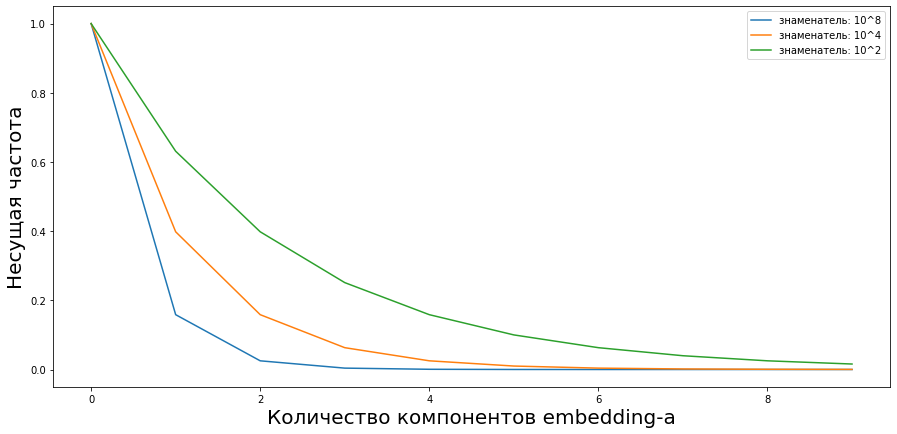

In [ ]:
#@title Зависимость размера вектора embedding-а от позиции слова
def make_carriers(d_mod, denom):
    return 1 / np.power(denom, np.arange(d_mod) / d_mod)

carriers = {i: make_carriers(10, 10**i) for i in (8, 4, 2)}
plt.figure(figsize=(15, 7))
for i, carrier in carriers.items():
    plt.plot(carrier, label=f'знаменатель: 10^{i}')
plt.legend()
plt.xlabel('Количество компонентов embedding-а', fontsize=20)
plt.ylabel('Несущая частота', fontsize=20)
plt.show()

На самом деле разные частоты соответствуют разным "часам", которые мы должны измерять как время.

Модель не знает значения pos напрямую, но она видит все "времена" (фактически фазы) разных "часов" (sin и cos разных частот).

Имея репрезентативный набор "часов", мы можем определенно сказать, сколько сейчас времени (значение pos) для каждого данного "момента" (значение .

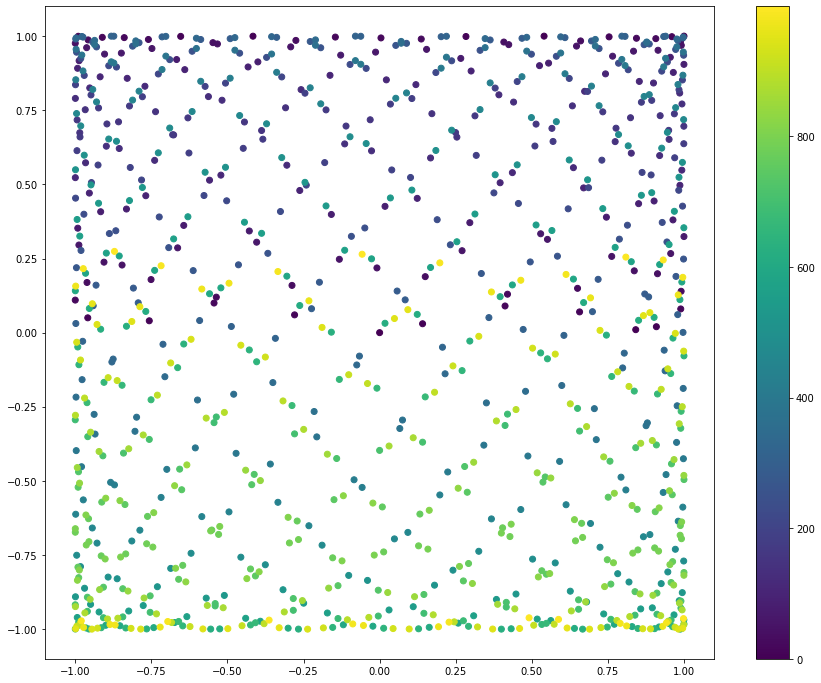

In [ ]:
#@title Пример с двумерным вектором, в который отображаем positional encoding (D_model = 2)

def make_pa_matrix(n_pos, d_mod, denom):
    res= np.empty((n_pos, d_mod))
    carriers = make_carriers(d_mod, denom)

    for pos in range(n_pos):
        if pos % 2:
            funct = np.sin
        else:
            funct = np.cos

        for i in range(d_mod):
            res[pos, i] = funct((pos // 2) * carriers[i])
    return res

pa2 = make_pa_matrix(1000, 2, 10**4)

plt.figure(figsize=(15, 12))
plt.scatter(pa2[:, 0], pa2[:, 1], c=np.arange(len(pa2)))
plt.colorbar()
plt.show()

In [ ]:
#@title Пример с трехмерным вектором, в который отображаем positional encoding (D_model = 3)
pa3 = make_pa_matrix(250, 3, 2**3)

pa3_df = pd.DataFrame(
    np.concatenate((pa3, np.arange(len(pa3))[:, None]), axis=1),
    columns=['x', 'y', 'z', 'c'],
)
pa3_df.head()

fig = px.scatter_3d(pa3_df, x='x', y='y', z='z', color='c')
fig.show()

In [ ]:
class PositionalEncoding(nn.Module):
    """
    Расчет позиционного кодирования
    """
    def __init__(self, d_model, max_len, device):
        """
        конструктор позиционного кодирования

        :param d_model: размерность эмбеддинга
        :param max_len: максимальная длина последовательности (кол-во слов)
        :param device: gpu / cpu
        """
        super(PositionalEncoding, self).__init__()

        # размер == размеру входной матрицы (кол-во слов * размер эмебддинга)
        self.encoding = torch.zeros(max_len, d_model, device=device)
        # градиент обовлять для них не нужно
        self.encoding.requires_grad = False

        # вектор-столбец позиций
        pos = torch.arange(0, max_len, device=device)
        pos = pos.float().unsqueeze(dim=1)

        # i - индекс от 0 до d_model (т.е. 0, 1, ...,  511)
        # "step=2" означает, что 'i' шагает с шагом 2
        _2i = torch.arange(0, d_model, step=2, device=device).float()
        
        # многомерные фигуры лиссажу
        self.encoding[:, 0::2] = torch.sin(pos / (10000 ** (_2i / d_model)))
        self.encoding[:, 1::2] = torch.cos(pos / (10000 ** (_2i / d_model)))

    def forward(self, x):
        # размер self.encoding [max_len = 512, d_model = 512]

        # размер входа [batch_size = 128, seq_len = 30]
        batch_size, seq_len = x.size()

        # [seq_len = 30, d_model = 512]
        # далее этот тензор мы добавим к эмбеддингу токенов tok_emb : [128, 30, 512]   
        return self.encoding[:seq_len, :]

In [ ]:
pe = PositionalEncoding(d_model, max_len, device='cpu')
x = torch.rand(4, 4)
pe(x)

tensor([[ 0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0100,  0.9999],
        [ 0.9093, -0.4161,  0.0200,  0.9998],
        [ 0.1411, -0.9900,  0.0300,  0.9996]])

### Token Embedding

In [ ]:
class TokenEmbedding(nn.Embedding):
    """
    Используем Embedding из torch.nn
    """

    def __init__(self, vocab_size, d_model):
        """
        класс для эмбеддинга токена, который включает позиционную информацию
        class for token embedding that included positional information
        :vocab_size: размер словаря
        :d_model: размер эмбеддинга токена
        """
        super(TokenEmbedding, self).__init__(vocab_size, d_model, padding_idx=1)

    '''
    Пояснения по padding_idx=1
    Когда мы с помощью long тензоров будем выбирать нужные строки из матрицы
    размера (кол-во слов * размер эмбеддинга) токены, которых нет будут в инпутах
    заменены на 0. При доставании вектора для 0 индекса получим вектор из нулей

    embedding = torch.nn.Embedding(10, 3, padding_idx=1)
    input = torch.LongTensor([[0, 1, 0, 5]])

    embedding(input)
    >>>
    tensor([[[ 0.0000,  0.0000,  0.0000],
         [-0.4448, -0.2076,  1.1575],
         [ 0.0000,  0.0000,  0.0000],
         [ 1.3602, -0.6299, -0.5809]]]
    '''

### Transformer Embedding

In [ ]:
class TransformerEmbedding(nn.Module):
    """
    token embedding + positional encoding (sinusoid)
    """

    def __init__(self, vocab_size, d_model, max_len, drop_prob, device):
        """
        класс для эмбеддинга токенов, которые включают позиционную информацию
        :vocab_size: размер словаря
        :d_model: размер эмбеддинга токена
        """
        super(TransformerEmbedding, self).__init__()
        self.tok_emb = TokenEmbedding(vocab_size, d_model)
        self.pos_emb = PositionalEncoding(d_model, max_len, device)
        self.drop_out = nn.Dropout(p=drop_prob)

    def forward(self, x):
        tok_emb = self.tok_emb(x)
        pos_emb = self.pos_emb(x)
        return self.drop_out(tok_emb + pos_emb)

## Scale Dot Product Attention

![](https://github.com/hyunwoongko/transformer/raw/master/image/scale_dot_product_attention.jpg)

In [ ]:
class ScaledDotProductAttention(nn.Module):
    """
    Расчет самовнимания (scale dot product attention)
    Query : предложение на котором фокусируемся (decoder)
    Key : каждое предложение с которым сравниваем Qeury(encoder)
    Value : значение, на которое накладываем результат (encoder)
    """
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, q, k, v, mask=None, e=1e-12):
        # вход - четырехмерный тензор:
        # [batch_size, head, length, d_tensor]
        batch_size, head, length, d_tensor = k.size()

        # скалярное Q * K.T для понятия схожести токенов
        k_t = k.transpose(2, 3)  # транспонируем

        score = (q @ k_t) / math.sqrt(d_tensor)  # scaled dot product

        # применение маскирования в декодере для того, чтоб не смотреть на еще не сгенерированные
        if mask is not None:
            score = score.masked_fill(mask == 0, -e)

        # применяем софтмакс для нормирования на [0, 1]
        score = self.softmax(score)
        # умножаем на V
        v = score @ v

        return v, score

In [ ]:
x = torch.rand(2, 2, 4, 5)

attention = ScaledDotProductAttention()
# 2 элемента в батче, 8 голов attention-а, 4 токена, эмбеддинг размера 5
attention(x, x, x)[0].size()

torch.Size([2, 2, 4, 5])

## Multi-Head Attention

![](https://github.com/hyunwoongko/transformer/raw/master/image/multi_head_attention.jpg)

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_head):
        super(MultiHeadAttention, self).__init__()
        self.n_head = n_head # количество голов
        self.attention = ScaledDotProductAttention() # нормированное самовнимание
        self.w_q = nn.Linear(d_model, d_model) # веса query
        self.w_k = nn.Linear(d_model, d_model) # веса key
        self.w_v = nn.Linear(d_model, d_model) # веса value
        self.w_concat = nn.Linear(d_model, d_model) 

    def forward(self, q, k, v, mask=None):
        # Отображаем вектора q, k, v
        q, k, v = self.w_q(q), self.w_k(k), self.w_v(v)

        # разделяем тензор по количеству голов
        q = self.split(q)
        k = self.split(k)
        v = self.split(v)
        
        # используем нормированное самовнимание для получения карт attention и обновленных векторов3. do scale dot product to compute similarity
        out, attention = self.attention(q, k, v, mask=mask)
        # конкатенация
        out = self.concat(out)
        # линейный слой
        out = self.w_concat(out)
        return out

    def split(self, tensor):
        """
        разделяем тензор по количеству голов

        :тензор: [batch_size, length, d_model]
        :возвращаем [batch_size, head, length, d_tensor]
        """
        batch_size, length, d_model = tensor.size()

        d_tensor = d_model // self.n_head
        # разделяем по количеству голов
        tensor = tensor.view(batch_size, length, self.n_head, d_tensor)

        tensor = tensor.transpose(1, 2)
        return tensor

    def concat(self, tensor):
        """
        Конкатенация (обратная функция split выше)

        :тензор: [batch_size, head, length, d_tensor]
        :возвращаем: [batch_size, length, d_model]
        """
        batch_size, head, length, d_tensor = tensor.size()
        d_model = head * d_tensor
        # транспонирование не меняет содержание а изменяют способ организации данных (метаданные)
        tensor = tensor.transpose(1, 2)
        # contiguous создаем смежный тензор (фактически создает копию тензора, так что
        # порядок его элементов в памяти такой же, как если бы он был создан с нуля с теми же данными.
        # подробнее https://androidkt.com/how-to-create-contiguous-tensor-in-pytorch/
        tensor = tensor.contiguous()
        # фактически конкатенация
        tensor = tensor.view(batch_size, length, d_model)
        return tensor

In [ ]:
x = torch.rand(2, 4, 4)
print('x', x, '\n')
# 2 элемента в батче, 4 голов attention-а, 4 токена, эмбеддинг размера 5
attention = MultiHeadAttention(d_model=4, n_head=2)
attention(x, x, x).size()

x tensor([[[0.9049, 0.7178, 0.2480, 0.1698],
         [0.9591, 0.1002, 0.2163, 0.2857],
         [0.3198, 0.3231, 0.1845, 0.8850],
         [0.8324, 0.3757, 0.3672, 0.0839]],

        [[0.1878, 0.9977, 0.2397, 0.0589],
         [0.2050, 0.2508, 0.3882, 0.0327],
         [0.6939, 0.1659, 0.6874, 0.4609],
         [0.2634, 0.5213, 0.0641, 0.5924]]]) 



torch.Size([2, 4, 4])

## Layer norm

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, d_model, eps=1e-12):
        super(LayerNorm, self).__init__()
        # делаем коэффициенты параметрами модели (обучаемыми числами)
        self.gamma = nn.Parameter(torch.ones(d_model))
        self.beta = nn.Parameter(torch.zeros(d_model))
        self.eps = eps

    def forward(self, x):
        # '-1' == по последнему измерению. 
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)

        out = (x - mean) / (std + self.eps)
        out = self.gamma * out + self.beta
        return out

ln = LayerNorm(d_model = 4)
ln(x)

tensor([[[ 1.1042,  0.5808, -0.7331, -0.9519],
         [ 1.4703, -0.7501, -0.4498, -0.2704],
         [-0.3477, -0.3371, -0.7825,  1.4674],
         [ 1.3485, -0.1263, -0.1536, -1.0686]],

        [[-0.4314,  1.4758, -0.3093, -0.7351],
         [-0.0965,  0.2157,  1.1523, -1.2714],
         [ 0.7708, -1.3505,  0.7448, -0.1652],
         [-0.3992,  0.6631, -1.2196,  0.9557]]], grad_fn=<AddBackward0>)

## Positionwise Feed Forward

![](https://github.com/hyunwoongko/transformer/raw/master/image/positionwise_feed_forward.jpg)

In [ ]:
class PositionwiseFeedForward(nn.Module):

    def __init__(self, d_model, hidden, drop_prob=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, hidden)
        self.linear2 = nn.Linear(hidden, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=drop_prob)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

pp = PositionwiseFeedForward(d_model=4, hidden=4)

pp(x)

tensor([[[-0.2776, -0.3338, -0.1494,  0.6653],
         [-0.2783, -0.3529, -0.1857,  0.6967],
         [-0.2231, -0.2841, -0.1794,  0.6101],
         [-0.2778, -0.3544, -0.1901,  0.6996]],

        [[-0.0810, -0.1542, -0.2580,  0.4660],
         [-0.2140, -0.2758, -0.1845,  0.6009],
         [-0.2590, -0.3169, -0.1596,  0.6465],
         [-0.2194, -0.2807, -0.1815,  0.6063]]], grad_fn=<ViewBackward0>)

## Encoder&Decoder Layer

![](https://github.com/hyunwoongko/transformer/raw/master/image/enc_dec.jpg)

In [ ]:
class EncoderLayer(nn.Module):

    def __init__(self, d_model, ffn_hidden, n_head, drop_prob):
        super(EncoderLayer, self).__init__()
        self.attention = MultiHeadAttention(d_model=d_model, n_head=n_head)
        self.norm1 = LayerNorm(d_model=d_model)
        self.dropout1 = nn.Dropout(p=drop_prob)

        self.ffn = PositionwiseFeedForward(d_model=d_model, hidden=ffn_hidden, drop_prob=drop_prob)
        self.norm2 = LayerNorm(d_model=d_model)
        self.dropout2 = nn.Dropout(p=drop_prob)

    def forward(self, x, src_mask):
        # для скипконнекшена
        _x = x
        # слой самовнимания
        x = self.attention(q=x, k=x, v=x, mask=src_mask)
        
        # скипконнектим и леернормим
        x = self.norm1(x + _x)
        # регуляризируем
        x = self.dropout1(x)
        
        # скипконнектим
        _x = x
        # positionwise feed forward network
        x = self.ffn(x)
      
        # 4. add and norm
        x = self.norm2(x + _x)
        x = self.dropout2(x)
        return x

In [ ]:
class DecoderLayer(nn.Module):

    def __init__(self, d_model, ffn_hidden, n_head, drop_prob):
        super(DecoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(d_model=d_model, n_head=n_head)
        self.norm1 = LayerNorm(d_model=d_model)
        self.dropout1 = nn.Dropout(p=drop_prob)

        self.enc_dec_attention = MultiHeadAttention(d_model=d_model, n_head=n_head)
        self.norm2 = LayerNorm(d_model=d_model)
        self.dropout2 = nn.Dropout(p=drop_prob)

        self.ffn = PositionwiseFeedForward(d_model=d_model, hidden=ffn_hidden, drop_prob=drop_prob)
        self.norm3 = LayerNorm(d_model=d_model)
        self.dropout3 = nn.Dropout(p=drop_prob)

    def forward(self, dec, enc, trg_mask, src_mask):    
        # для скипконнекшена
        _x = dec
        # слой самовнимания
        x = self.self_attention(q=dec, k=dec, v=dec, mask=trg_mask)
        
        # скипконнектим и леернормим
        x = self.norm1(x + _x)
        # регуляризируем
        x = self.dropout1(x)

        if enc is not None:
            # для скипконнекшена
            _x = x
            # encoder - decoder attention
            x = self.enc_dec_attention(q=x, k=enc, v=enc, mask=src_mask)
            
            # скипконнектим и леернормим
            x = self.norm2(x + _x)
            # регуляризируем
            x = self.dropout2(x)

        # для скипконнекшена
        _x = x
        # positionwise feed forward network
        x = self.ffn(x)
        
        # скипконнектим и леернормим
        x = self.norm3(x + _x)
        # регуляризируем
        x = self.dropout3(x)
        return x

## Encoder&Decoder

In [ ]:
class Encoder(nn.Module):

    def __init__(self, enc_voc_size, max_len, d_model, ffn_hidden, n_head, n_layers, drop_prob, device):
        super().__init__()
        self.emb = TransformerEmbedding(d_model=d_model,
                                        max_len=max_len,
                                        vocab_size=enc_voc_size,
                                        drop_prob=drop_prob,
                                        device=device)

        self.layers = nn.ModuleList([EncoderLayer(d_model=d_model,
                                                  ffn_hidden=ffn_hidden,
                                                  n_head=n_head,
                                                  drop_prob=drop_prob)
                                     for _ in range(n_layers)])

    def forward(self, x, src_mask):
        x = self.emb(x)

        for layer in self.layers:
            x = layer(x, src_mask)

        return x

In [ ]:
class Decoder(nn.Module):
    def __init__(self, dec_voc_size, max_len, d_model, ffn_hidden, n_head, n_layers, drop_prob, device):
        super().__init__()
        self.emb = TransformerEmbedding(d_model=d_model,
                                        drop_prob=drop_prob,
                                        max_len=max_len,
                                        vocab_size=dec_voc_size,
                                        device=device)

        self.layers = nn.ModuleList([DecoderLayer(d_model=d_model,
                                                  ffn_hidden=ffn_hidden,
                                                  n_head=n_head,
                                                  drop_prob=drop_prob)
                                     for _ in range(n_layers)])

        self.linear = nn.Linear(d_model, dec_voc_size)

    def forward(self, trg, src, trg_mask, src_mask):
        trg = self.emb(trg)

        for layer in self.layers:
            trg = layer(trg, src, trg_mask, src_mask)

        # выход на голову для генерации языка
        output = self.linear(trg)
        return output

# Transformer

In [ ]:
class Transformer(nn.Module):

    def __init__(self, src_pad_idx, trg_pad_idx, trg_sos_idx, enc_voc_size, dec_voc_size, d_model, n_head, max_len,
                 ffn_hidden, n_layers, drop_prob, device):
        super().__init__()
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.trg_sos_idx = trg_sos_idx
        self.device = device
        self.encoder = Encoder(d_model=d_model,
                               n_head=n_head,
                               max_len=max_len,
                               ffn_hidden=ffn_hidden,
                               enc_voc_size=enc_voc_size,
                               drop_prob=drop_prob,
                               n_layers=n_layers,
                               device=device)

        self.decoder = Decoder(d_model=d_model,
                               n_head=n_head,
                               max_len=max_len,
                               ffn_hidden=ffn_hidden,
                               dec_voc_size=dec_voc_size,
                               drop_prob=drop_prob,
                               n_layers=n_layers,
                               device=device)

    def forward(self, src, trg):
        src_mask = self.make_pad_mask(src, src)

        src_trg_mask = self.make_pad_mask(trg, src)

        trg_mask = self.make_pad_mask(trg, trg) * \
                   self.make_no_peak_mask(trg, trg)

        enc_src = self.encoder(src, src_mask)
        output = self.decoder(trg, enc_src, trg_mask, src_trg_mask)
        return output

    # маскирование следующих токенов
    def make_pad_mask(self, q, k):
        len_q, len_k = q.size(1), k.size(1)

        # batch_size x 1 x 1 x len_k
        k = k.ne(self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        # batch_size x 1 x len_q x len_k
        k = k.repeat(1, 1, len_q, 1)

        # batch_size x 1 x len_q x 1
        q = q.ne(self.src_pad_idx).unsqueeze(1).unsqueeze(3)
        # batch_size x 1 x len_q x len_k
        q = q.repeat(1, 1, 1, len_k)

        mask = k & q
        return mask

    def make_no_peak_mask(self, q, k):
        len_q, len_k = q.size(1), k.size(1)

        # len_q x len_k
        mask = torch.tril(torch.ones(len_q, len_k)).type(torch.BoolTensor).to(self.device)

        return mask